In [1]:
import pprint
import time
from pathlib import Path

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
from hydra import compose, initialize
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from sklearn.model_selection import StratifiedKFold

from src.seed import seed_everything


with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


lgb:
  params:
    objective: binary
    metric: auc
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.01
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 20
    bagging_fraction: 0.8
    bagging_freq: 1
    feature_fraction: 0.8
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
exp_number: '001'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  clothing_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/001/base
seed: 42
n_splits: 5
target: Recommended IND



### Import

In [2]:
train_df = pd.read_csv(cfg.data.train_path)
clothing_df = pd.read_csv(cfg.data.clothing_path)
test_df = pd.read_csv(cfg.data.test_path)

train_df = train_df.merge(clothing_df, how="left", on="Clothing ID")
test_df = test_df.merge(clothing_df, how="left", on="Clothing ID")
all_df = pd.concat([train_df, test_df])

features = [
    'Clothing ID',
    'Age',
    'Title',
    'Review Text',
    # 'Rating',
    # 'Recommended IND',
    'Positive Feedback Count',
    'Division Name',
    'Department Name',
    'Class Name',
]
num_features = ['Age']
cat_features = ['Clothing ID', 'Title', 'Review Text', 'Division Name', 'Department Name', 'Class Name']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.seed)


### 特徴量加工

In [3]:
# CountEncoding. all_dfで集計していることに注意
# for col in cat_features:
#     count_map = all_df[col].value_counts()
#     train_df[f"count_{col}"] = train_df[col].map(count_map)
#     test_df[f"count_{col}"] = test_df[col].map(count_map)

# GroupbyEncoding. all_dfで集計していることに注意
# methods = ["mean", "std", "min", "max", "median"]
# for grp_col in cat_features:
#     grp_df = all_df.groupby(grp_col)[num_features].agg(methods).reset_index()
#     grp_df.columns = [grp_col] + [f"grpby_{grp_col}_{col}_{m}" for m in methods for col in num_features]
#     train_df = train_df.merge(grp_df, how="left", on=grp_col)
#     test_df = test_df.merge(grp_df, how="left", on=grp_col)

# TargetEncoding. 一応リークに気を付けているが要注意
# for col in cat_features:
#     for tr_idx, va_idx in kf.split(train_df, train_df[cfg.target], groups=groups):
#         group = train_df.iloc[tr_idx].groupby(col)[cfg.target].mean().to_dict()
#         train_df.loc[va_idx, f"target_{col}"] = train_df.loc[va_idx, col].map(group)
#     group = train_df.groupby(col)[cfg.target].mean().to_dict()
#     test_df[f"target_{col}"] = test_df[col].map(group)

# Ratingがtestにはない→testのRatingはtrainのRatingの平均値で埋める
_map = train_df.groupby("Clothing ID")["Rating"].mean().to_dict()
test_df["Rating"] = test_df["Clothing ID"].map(_map)

# CategoryEncoding
for col in cat_features:
    train_df[col] = train_df[col].astype("category")
    test_df[col] = test_df[col].astype("category")


### 学習

In [4]:
x_train = train_df.drop([cfg.target], axis=1)
y_train = train_df[cfg.target]

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

# 学習設定
lgb_data = lgb.Dataset(
    x_train,
    label=y_train,
    categorical_feature=x_train.select_dtypes(include=["category"]).columns.tolist(),
    free_raw_data=True,
)
callbacks=[
    lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
    lgb.log_evaluation(cfg.lgb.log_evaluation),
]

# 学習
cv_results = lgb.cv(
    dict(cfg.lgb.params),
    lgb_data,
    folds=kf.split(x_train, y_train),
    num_boost_round=cfg.lgb.num_boost_round,
    callbacks=callbacks,
    return_cvbooster=True,
    stratified=False,
    seed=cfg.seed,
)

# 学習モデル保存
cvbooster = cv_results["cvbooster"]
cvbooster.save_model(f"{cfg.data.results_dir}/model.pkl")


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid auc: 0.972475 + 0.00314695
[200]	cv_agg's valid auc: 0.972869 + 0.00283848
[300]	cv_agg's valid auc: 0.973206 + 0.00272592
[400]	cv_agg's valid auc: 0.973566 + 0.00276507
[500]	cv_agg's valid auc: 0.973516 + 0.00264159
Early stopping, best iteration is:
[423]	cv_agg's valid auc: 0.973576 + 0.00276215


### log

In [5]:
best_iteration = cvbooster.best_iteration
best_score = cv_results["valid auc-mean"][best_iteration - 1]
best_score_stdv = cv_results["valid auc-stdv"][best_iteration - 1]

with open(f"{cfg.data.results_dir}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_iteration: {best_iteration}\n")
    log_file.write(f"best_score: {best_score}\n")
    log_file.write(f"best_score_stdv: {best_score_stdv}\n")

    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

    log_file.write("\n====== feature name ======\n")
    log_file.write(pprint.pformat(cvbooster.feature_name()[0]))


### Feature Importance

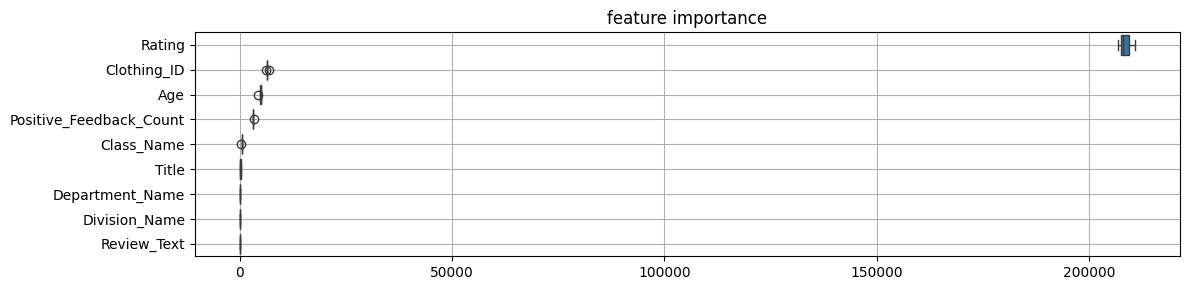

In [6]:
# 学習済みモデルから特徴量の重要度を取り出す
raw_importances = cvbooster.feature_importance(importance_type="gain")
importance_df = pd.DataFrame(data=raw_importances, columns=cvbooster.feature_name()[0])

# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロット -> 保存
plot_cols = sorted_importance_df.columns[:50]
fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
ax.grid()
ax.set_title("feature importance")
fig.tight_layout()
plt.show()
fig.savefig(f"{cfg.data.results_dir}/feature_importance.png")


### oof

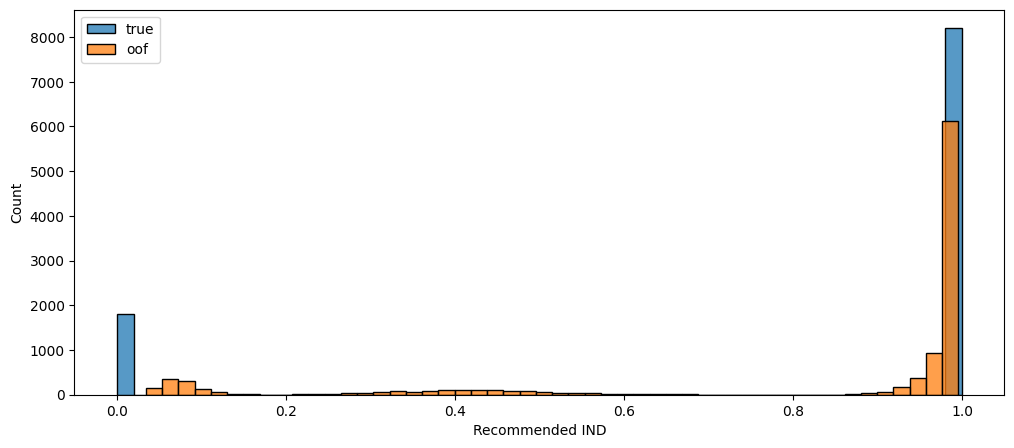

In [7]:
oof = np.zeros(len(x_train))

# 各fold毎に推論してoofを作成
for i, (_, valid_idx) in enumerate(kf.split(x_train, y_train)):
    x_valid = x_train.iloc[valid_idx]
    model = cvbooster.boosters[i]
    y_pred = model.predict(x_valid, num_iteration=cvbooster.best_iteration)
    oof[valid_idx] = y_pred

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof.csv", index=False)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")


### Submission

In [8]:
# 推論
y_preds = cvbooster.predict(test_df, num_iteration=cvbooster.best_iteration)
y_pred = np.mean(y_preds, axis=0)

# 提出用ファイル作成
sub_df = pd.read_csv(cfg.data.sample_submission_path)
sub_df["target"] = y_pred
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
sub_df.head()


,target
0,0.060364
1,0.065441
2,0.059946
3,0.993742
4,0.060282
